# Decision Tree with Lag/MA + Interaction Features and Hyperparameter Tuning

This notebook extends the lag/MA model by adding four **interaction features**:
- `CO(GT) * NOx(GT)`
- `CO(GT) * NO2(GT)`
- `CO(GT) * RH`
- `NOx(GT) * hour`

Original features are kept; these interactions are added on top. We then redo
hyperparameter tuning on the validation set and evaluate on the test set.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 120

HORIZONS = [1, 6, 12, 24]
TARGET = "CO(GT)"


## 1. Load train / validation / test sets

In [2]:

train = pd.read_csv("data/splits/airq_train.csv", parse_dates=["timestamp"])
val   = pd.read_csv("data/splits/airq_val.csv",   parse_dates=["timestamp"])
test  = pd.read_csv("data/splits/airq_test.csv",  parse_dates=["timestamp"])

print("Train shape:", train.shape)
print("Val shape:  ", val.shape)
print("Test shape: ", test.shape)
display(train.head())


Train shape: (6550, 14)
Val shape:   (1404, 14)
Test shape:  (1403, 14)


,timestamp,CO(GT),NMHC(GT),C6H6(GT),NOx(GT),NO2(GT),PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10 18:00:00,2.6,150.0,11.9,166.0,113.0,1360.0,1046.0,1056.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004-03-10 19:00:00,2.0,112.0,9.4,103.0,92.0,1292.0,955.0,1174.0,1559.0,972.0,13.3,47.7,0.7255
2,2004-03-10 20:00:00,2.2,88.0,9.0,131.0,114.0,1402.0,939.0,1140.0,1555.0,1074.0,11.9,54.0,0.7502
3,2004-03-10 21:00:00,2.2,80.0,9.2,172.0,122.0,1376.0,948.0,1092.0,1584.0,1203.0,11.0,60.0,0.7867
4,2004-03-10 22:00:00,1.6,51.0,6.5,131.0,116.0,1272.0,836.0,1205.0,1490.0,1110.0,11.2,59.6,0.7888


## 2. Drop `NMHC(GT)` and add time features

In [3]:

for df in (train, val, test):
    if "NMHC(GT)" in df.columns:
        df.drop(columns=["NMHC(GT)"], inplace=True)

    df["hour"] = df["timestamp"].dt.hour
    df["weekday"] = df["timestamp"].dt.weekday
    df["month"] = df["timestamp"].dt.month

print(train.dtypes)


timestamp        datetime64[ns]
CO(GT)                  float64
C6H6(GT)                float64
NOx(GT)                 float64
NO2(GT)                 float64
PT08.S1(CO)             float64
PT08.S2(NMHC)           float64
PT08.S3(NOx)            float64
PT08.S4(NO2)            float64
PT08.S5(O3)             float64
T                       float64
RH                      float64
AH                      float64
hour                      int32
weekday                   int32
month                     int32
dtype: object


## 3. Add lag features and moving averages for CO(GT)

In [4]:

def add_lag_ma(df, base_cols, lags, mas):
    df = df.sort_values("timestamp").copy()
    for col in base_cols:
        for h in lags:
            df[f"{col}_lag_{h}"] = df[col].shift(h)
        for w in mas:
            df[f"{col}_ma_{w}"] = df[col].rolling(window=w).mean()
    return df

lag_hours = [1, 6, 12, 24]
ma_windows = [3, 6, 12, 24]
base_cols = [TARGET]

train = add_lag_ma(train, base_cols, lag_hours, ma_windows)
val   = add_lag_ma(val,   base_cols, lag_hours, ma_windows)
test  = add_lag_ma(test,  base_cols, lag_hours, ma_windows)

print("Columns after lag/MA added:")
print(train.columns)


Columns after lag/MA added:
Index(['timestamp', 'CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'PT08.S1(CO)',
       'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T',
       'RH', 'AH', 'hour', 'weekday', 'month', 'CO(GT)_lag_1', 'CO(GT)_lag_6',
       'CO(GT)_lag_12', 'CO(GT)_lag_24', 'CO(GT)_ma_3', 'CO(GT)_ma_6',
       'CO(GT)_ma_12', 'CO(GT)_ma_24'],
      dtype='object')


## 4. Add interaction features (CO*NOx, CO*NO2, CO*RH, NOx*hour)

In [5]:

def add_interactions(df):
    df = df.copy()
    needed = ["CO(GT)", "NOx(GT)", "NO2(GT)", "RH", "hour"]
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns for interactions: {missing}")

    df["CO_NOx"]   = df["CO(GT)"] * df["NOx(GT)"]
    df["CO_NO2"]   = df["CO(GT)"] * df["NO2(GT)"]
    df["CO_RH"]    = df["CO(GT)"] * df["RH"]
    df["NOx_hour"] = df["NOx(GT)"] * df["hour"]
    return df

train = add_interactions(train)
val   = add_interactions(val)
test  = add_interactions(test)

[c for c in train.columns if c in ["CO_NOx","CO_NO2","CO_RH","NOx_hour"]]


['CO_NOx', 'CO_NO2', 'CO_RH', 'NOx_hour']

## 5. Construct horizon targets (1h, 6h, 12h, 24h ahead)

In [6]:

def discretise_co(values):
    bins = [-np.inf, 1.5, 2.5, np.inf]
    labels = ["low", "mid", "high"]
    return pd.cut(values, bins=bins, labels=labels)

def add_targets(df):
    df = df.sort_values("timestamp").copy()
    for h in HORIZONS:
        shifted = df[TARGET].shift(-h)
        df[f"y_{h}h"] = discretise_co(shifted)
    return df

train = add_targets(train)
val   = add_targets(val)
test  = add_targets(test)

train[["timestamp"] + [f"y_{h}h" for h in HORIZONS]].head()


,timestamp,y_1h,y_6h,y_12h,y_24h
0,2004-03-10 18:00:00,mid,low,low,high
1,2004-03-10 19:00:00,mid,low,low,high
2,2004-03-10 20:00:00,mid,low,mid,high
3,2004-03-10 21:00:00,mid,low,mid,high
4,2004-03-10 22:00:00,low,NaN,mid,low


## 6. Helper to build X / y for one horizon

In [7]:

def build_xy(df, h):
    y_col = f"y_{h}h"
    df2 = df.dropna(subset=[y_col]).copy()
    y = df2[y_col]
    drop_cols = ["timestamp"] + [f"y_{k}h" for k in HORIZONS]
    feature_cols = [c for c in df2.columns if c not in drop_cols]
    X = df2[feature_cols]
    return X, y, feature_cols

X_train_1h, y_train_1h, feat_1h = build_xy(train, 1)
print("1h horizon – X_train shape:", X_train_1h.shape)
print("Number of features:", len(feat_1h))


1h horizon – X_train shape: (5066, 27)
Number of features: 27


## 7. Baseline Decision Tree run (fixed hyperparameters)

In [8]:

def run_model_fixed(h, depth=7, leaf=30):
    print("="*60)
    print(f"Horizon: {h} hour(s) ahead – fixed params (depth={depth}, leaf={leaf})")

    Xtr, ytr, _ = build_xy(train, h)
    Xv,  yv,  _ = build_xy(val,   h)
    Xte, yte, _ = build_xy(test,  h)

    pipe = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("clf", DecisionTreeClassifier(max_depth=depth,
                                       min_samples_leaf=leaf,
                                       random_state=42)),
    ])
    pipe.fit(Xtr, ytr)
    val_acc = accuracy_score(yv, pipe.predict(Xv))
    test_pred = pipe.predict(Xte)
    test_acc = accuracy_score(yte, test_pred)

    co_now = test.loc[Xte.index, TARGET]
    baseline_pred = discretise_co(co_now)
    mask = baseline_pred.notna()
    baseline_acc = accuracy_score(yte[mask], baseline_pred[mask])

    print(f"Val accuracy (fixed): {val_acc:.4f}")
    print(f"Test accuracy (Decision Tree, fixed): {test_acc:.4f}")
    print(f"Test accuracy (naïve baseline):        {baseline_acc:.4f}")

for h in HORIZONS:
    run_model_fixed(h)


Horizon: 1 hour(s) ahead – fixed params (depth=7, leaf=30)
Val accuracy (fixed): 0.6837
Test accuracy (Decision Tree, fixed): 0.7515
Test accuracy (naïve baseline):        0.7519
Horizon: 6 hour(s) ahead – fixed params (depth=7, leaf=30)
Val accuracy (fixed): 0.5212
Test accuracy (Decision Tree, fixed): 0.5640
Test accuracy (naïve baseline):        0.3725
Horizon: 12 hour(s) ahead – fixed params (depth=7, leaf=30)
Val accuracy (fixed): 0.5442
Test accuracy (Decision Tree, fixed): 0.6260
Test accuracy (naïve baseline):        0.4009
Horizon: 24 hour(s) ahead – fixed params (depth=7, leaf=30)
Val accuracy (fixed): 0.5802
Test accuracy (Decision Tree, fixed): 0.5360
Test accuracy (naïve baseline):        0.6275


## 8. Hyperparameter tuning on validation set

In [9]:

param_grid_depth = [5, 7, 9, 11]
param_grid_leaf = [10, 20, 30, 50]

def tune_params_for_horizon(h):
    print("\n" + "-"*60)
    print(f"Hyperparameter tuning for horizon {h}h")

    Xtr, ytr, _ = build_xy(train, h)
    Xv,  yv,  _ = build_xy(val,   h)

    best_acc = -1.0
    best_params = None

    for d in param_grid_depth:
        for leaf in param_grid_leaf:
            pipe = Pipeline([
                ("imp", SimpleImputer(strategy="median")),
                ("clf", DecisionTreeClassifier(max_depth=d,
                                               min_samples_leaf=leaf,
                                               random_state=42)),
            ])
            pipe.fit(Xtr, ytr)
            val_pred = pipe.predict(Xv)
            acc = accuracy_score(yv, val_pred)
            print(f"max_depth={d:2d}, min_samples_leaf={leaf:2d} -> val_acc={acc:.4f}")
            if acc > best_acc:
                best_acc = acc
                best_params = (d, leaf)

    print(f"--> Best params for {h}h: max_depth={best_params[0]}, "
          f"min_samples_leaf={best_params[1]}, val_acc={best_acc:.4f}")
    return best_params

best_params = {}
for h in HORIZONS:
    best_params[h] = tune_params_for_horizon(h)

print("\nSummary of best params per horizon:")
for h in HORIZONS:
    d, leaf = best_params[h]
    print(f"  h={h}h -> max_depth={d}, min_samples_leaf={leaf}")



------------------------------------------------------------
Hyperparameter tuning for horizon 1h
max_depth= 5, min_samples_leaf=10 -> val_acc=0.6740
max_depth= 5, min_samples_leaf=20 -> val_acc=0.6756
max_depth= 5, min_samples_leaf=30 -> val_acc=0.6715
max_depth= 5, min_samples_leaf=50 -> val_acc=0.7186
max_depth= 7, min_samples_leaf=10 -> val_acc=0.6942
max_depth= 7, min_samples_leaf=20 -> val_acc=0.7097
max_depth= 7, min_samples_leaf=30 -> val_acc=0.6837
max_depth= 7, min_samples_leaf=50 -> val_acc=0.7356
max_depth= 9, min_samples_leaf=10 -> val_acc=0.7210
max_depth= 9, min_samples_leaf=20 -> val_acc=0.6975
max_depth= 9, min_samples_leaf=30 -> val_acc=0.6805
max_depth= 9, min_samples_leaf=50 -> val_acc=0.7340
max_depth=11, min_samples_leaf=10 -> val_acc=0.7226
max_depth=11, min_samples_leaf=20 -> val_acc=0.6983
max_depth=11, min_samples_leaf=30 -> val_acc=0.6805
max_depth=11, min_samples_leaf=50 -> val_acc=0.7340
--> Best params for 1h: max_depth=7, min_samples_leaf=50, val_acc=0.7

## 9. Final tuned models (train on train+val, evaluate on test)


Final model for horizon 1h (max_depth=7, min_samples_leaf=50)
Test accuracy (tuned): 0.7369
Test accuracy (naïve baseline): 0.7519

Classification report (tuned model, test set):
              precision    recall  f1-score   support

        high      0.717     0.795     0.754       341
         low      0.858     0.819     0.838       651
         mid      0.555     0.545     0.550       380

    accuracy                          0.737      1372
   macro avg      0.710     0.719     0.714      1372
weighted avg      0.739     0.737     0.737      1372



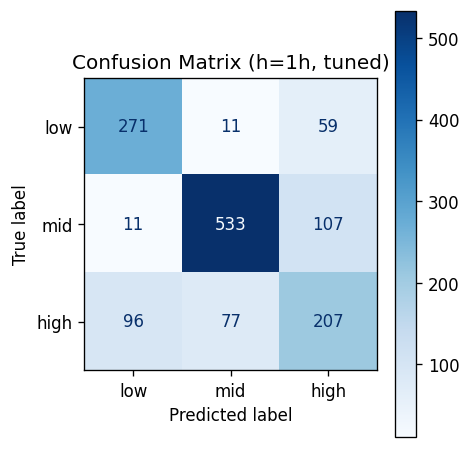

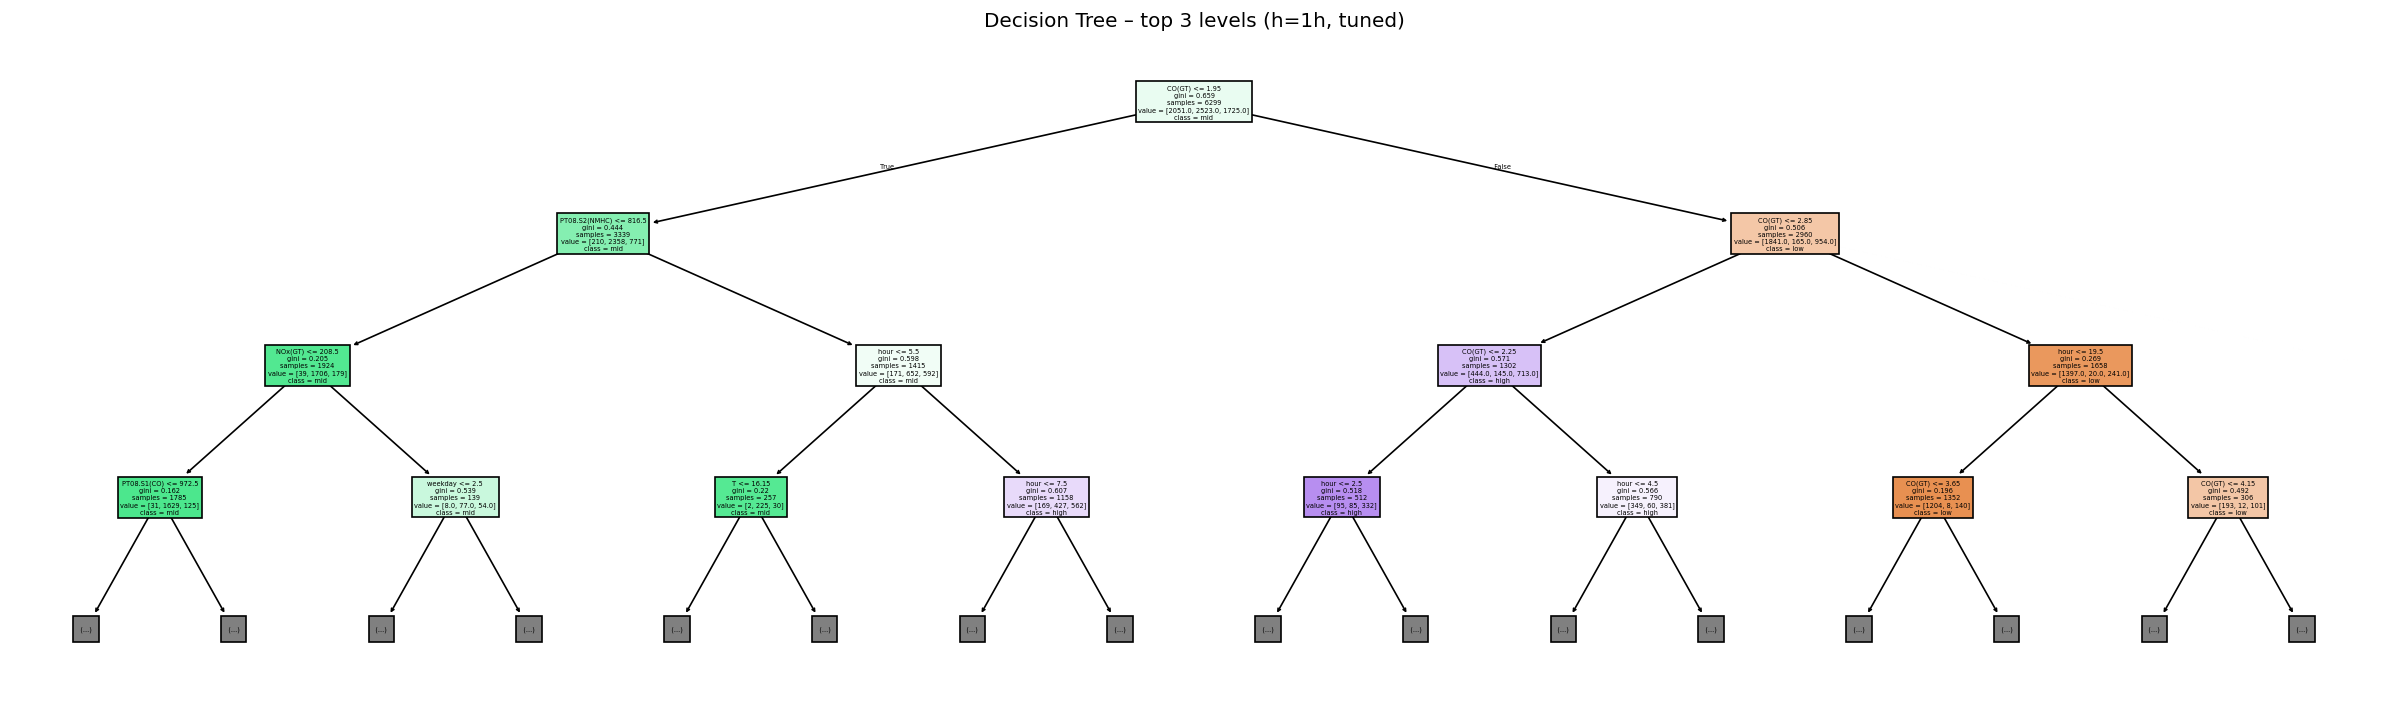


Final model for horizon 6h (max_depth=9, min_samples_leaf=50)
Test accuracy (tuned): 0.6020
Test accuracy (naïve baseline): 0.3725

Classification report (tuned model, test set):
              precision    recall  f1-score   support

        high      0.510     0.696     0.589       339
         low      0.790     0.690     0.736       648
         mid      0.414     0.368     0.390       380

    accuracy                          0.602      1367
   macro avg      0.571     0.585     0.572      1367
weighted avg      0.616     0.602     0.603      1367



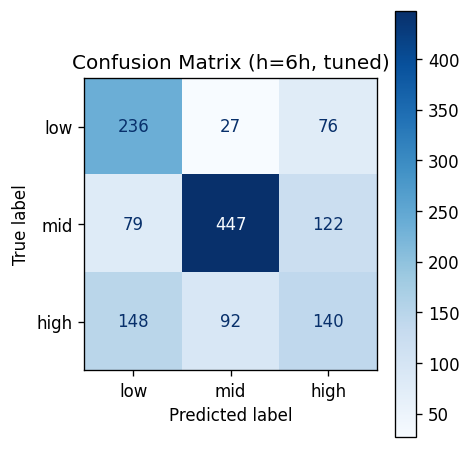

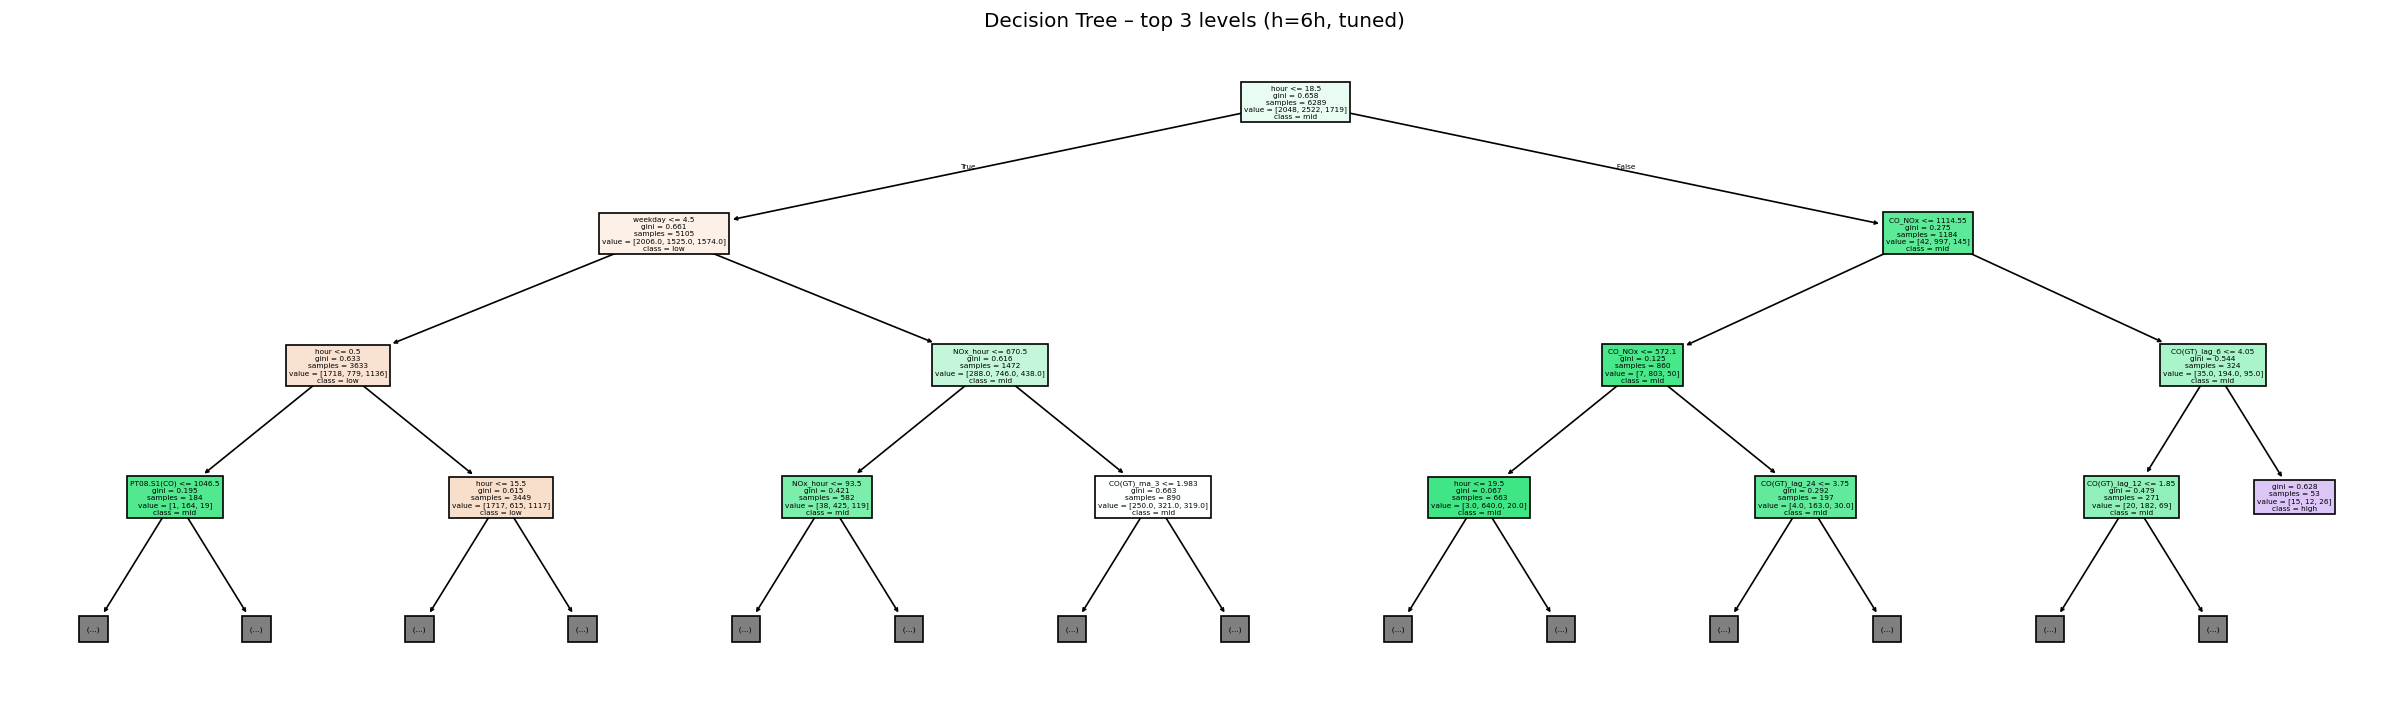


Final model for horizon 12h (max_depth=9, min_samples_leaf=50)
Test accuracy (tuned): 0.5988
Test accuracy (naïve baseline): 0.4009

Classification report (tuned model, test set):
              precision    recall  f1-score   support

        high      0.487     0.720     0.581       339
         low      0.779     0.692     0.733       642
         mid      0.438     0.334     0.379       380

    accuracy                          0.599      1361
   macro avg      0.568     0.582     0.564      1361
weighted avg      0.611     0.599     0.596      1361



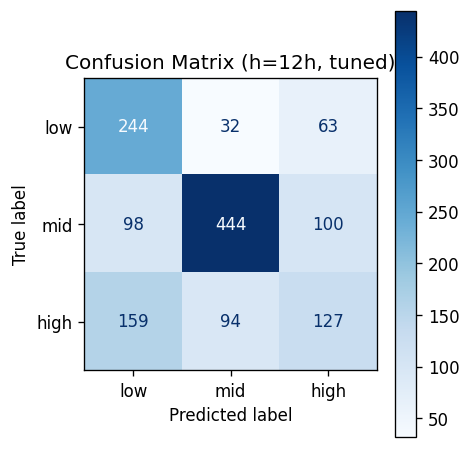

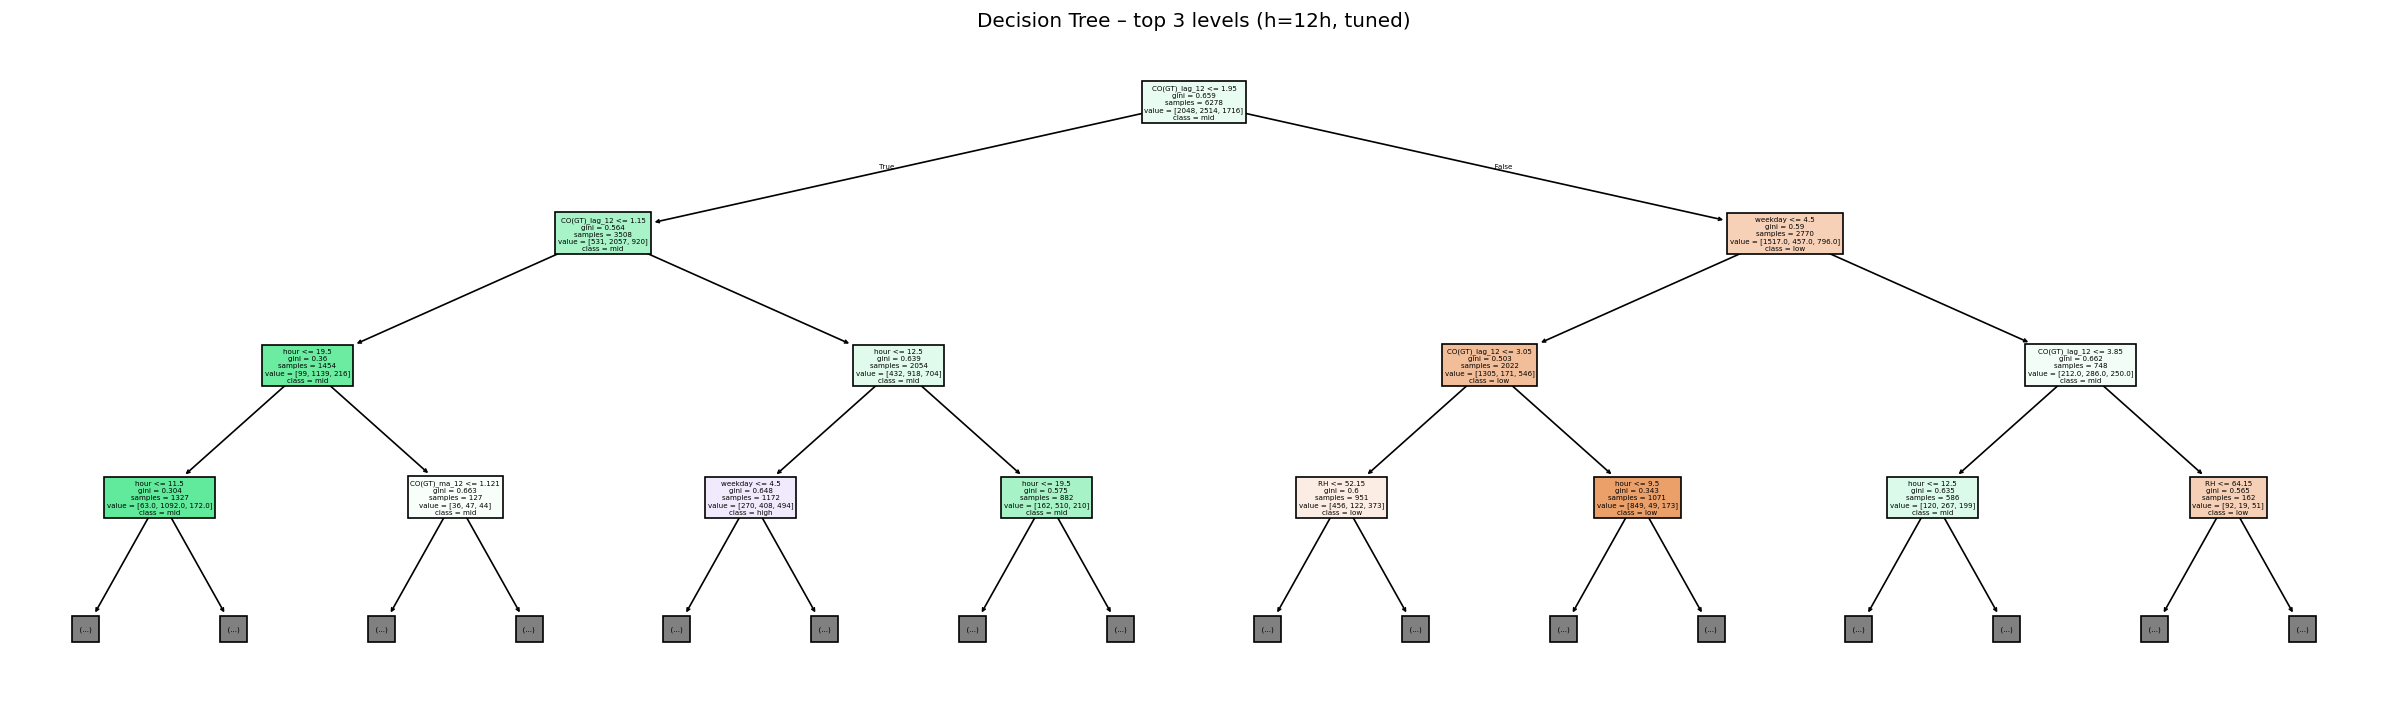


Final model for horizon 24h (max_depth=7, min_samples_leaf=50)
Test accuracy (tuned): 0.5782
Test accuracy (naïve baseline): 0.6275

Classification report (tuned model, test set):
              precision    recall  f1-score   support

        high      0.442     0.773     0.562       339
         low      0.830     0.663     0.737       632
         mid      0.394     0.262     0.315       378

    accuracy                          0.578      1349
   macro avg      0.555     0.566     0.538      1349
weighted avg      0.610     0.578     0.575      1349



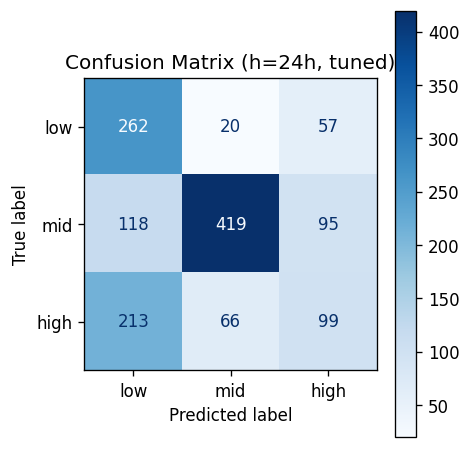

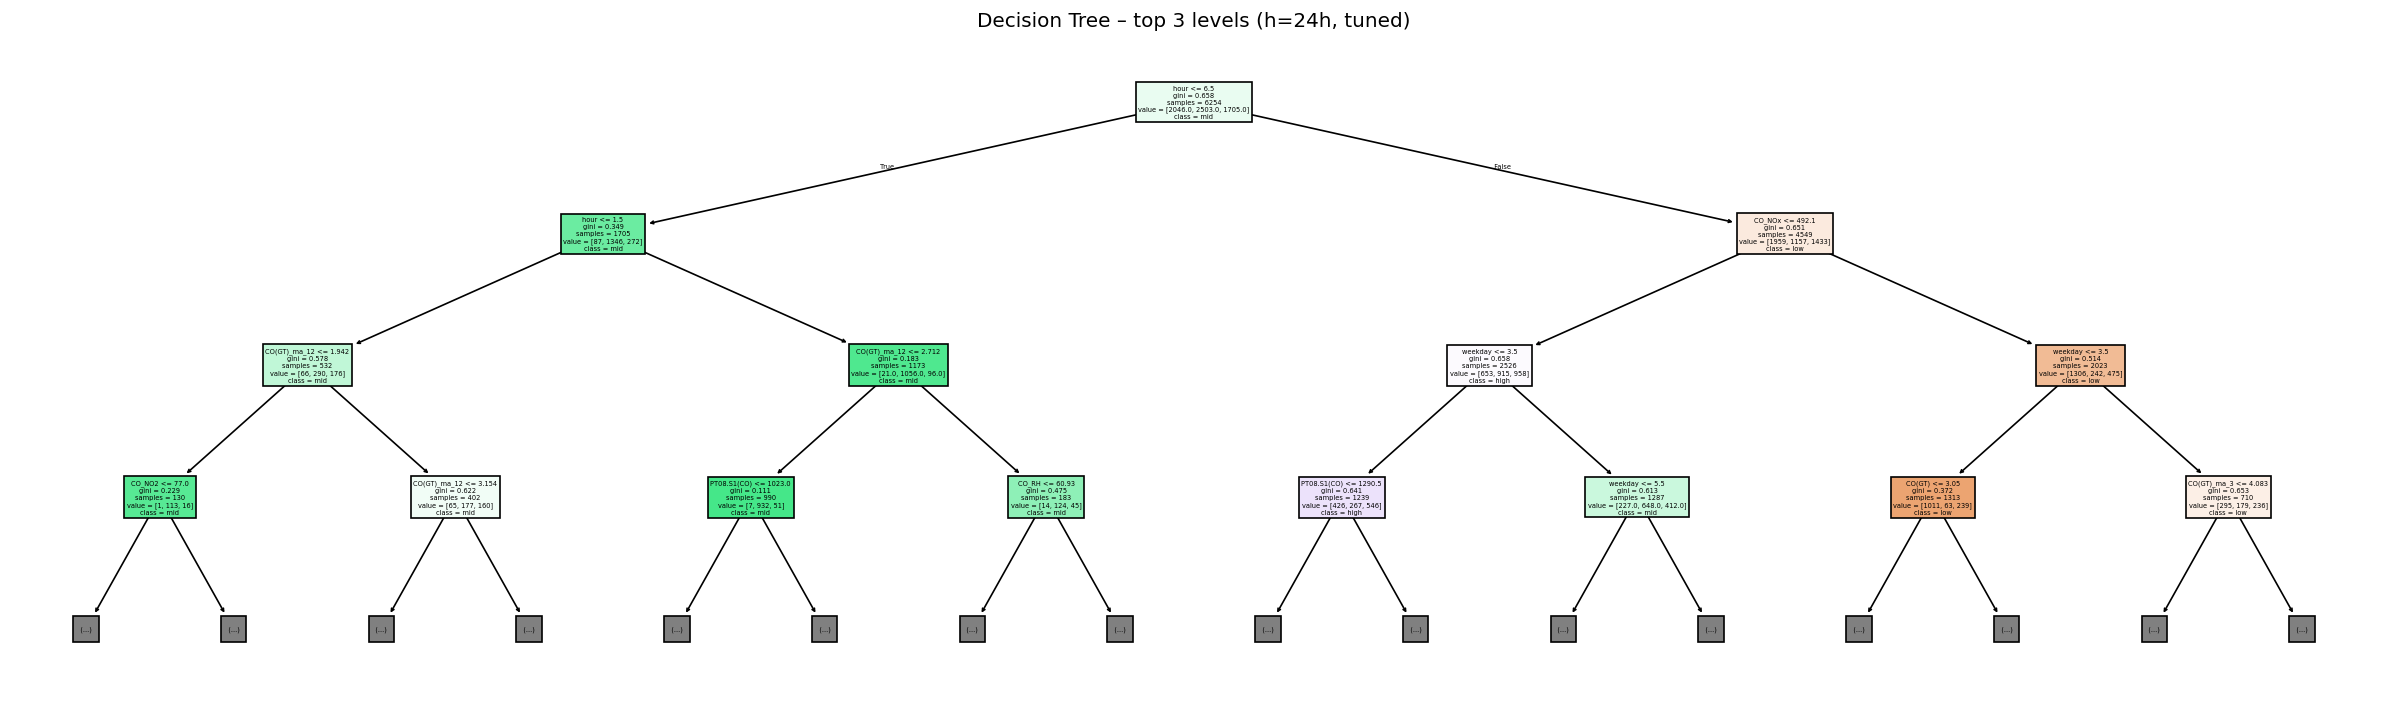

In [10]:

def run_final_with_params(h, depth, leaf):
    print("\n" + "="*60)
    print(f"Final model for horizon {h}h (max_depth={depth}, min_samples_leaf={leaf})")

    Xtr, ytr, feat_cols = build_xy(train, h)
    Xv,  yv,  _         = build_xy(val,   h)
    Xte, yte, _         = build_xy(test,  h)

    X_train_full = pd.concat([Xtr, Xv], axis=0)
    y_train_full = pd.concat([ytr, yv], axis=0)

    pipe = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("clf", DecisionTreeClassifier(max_depth=depth,
                                       min_samples_leaf=leaf,
                                       random_state=42)),
    ])
    pipe.fit(X_train_full, y_train_full)

    test_pred = pipe.predict(Xte)
    test_acc = accuracy_score(yte, test_pred)
    print(f"Test accuracy (tuned): {test_acc:.4f}")

    co_now = test.loc[Xte.index, TARGET]
    baseline_pred = discretise_co(co_now)
    mask = baseline_pred.notna()
    baseline_acc = accuracy_score(yte[mask], baseline_pred[mask])
    print(f"Test accuracy (naïve baseline): {baseline_acc:.4f}")

    print("\nClassification report (tuned model, test set):")
    print(classification_report(yte, test_pred, digits=3))

    fig, ax = plt.subplots(figsize=(4,4))
    ConfusionMatrixDisplay.from_predictions(yte, test_pred,
                                            display_labels=["low","mid","high"],
                                            cmap="Blues",
                                            ax=ax)
    ax.set_title(f"Confusion Matrix (h={h}h, tuned)")
    plt.tight_layout()
    plt.show()

    clf = pipe.named_steps["clf"]
    plt.figure(figsize=(20,6))
    plot_tree(clf,
              feature_names=feat_cols,
              class_names=["low","mid","high"],
              filled=True,
              max_depth=3)
    plt.title(f"Decision Tree – top 3 levels (h={h}h, tuned)")
    plt.tight_layout()
    plt.show()

for h in HORIZONS:
    d, leaf = best_params[h]
    run_final_with_params(h, d, leaf)
